# Finding the temporal autocorrelation order and evidence of slope
This notebook fits an ARIMA model for ADPE at CROZIER

In [1]:
# Load libraries
library(forecast); library(ggplot2);library(dplyr); library(fmsb); library(stats); library(ggplot2);
library(modelr); library(lmtest); library(pdp);library(nlme)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


The following object is masked from ‘package:forecast’:

    getResponse




In [2]:
# Load the data
master<-read.csv("~/Workspace/Anthropocene/data/MASTER_SIE_MOD.csv")

In [3]:
head(master)


,year,intP_RSP,mnChl_aw_RSP,mnOW_RSP,nmSST_aw_RSP,intP_MCM,mnChl_aw_MCM,mnOW_MCM,nmSST_aw_MCM,mnAirTemp,⋯,ICEBERG,ADPE_BIRD,ADPE_CROZ,ADPE_RO,BIRD,EMPE,WESE,WESE_1,av_SIE,FIE
,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1998,0.6511596,1.161487,250157,-0.690398,0.7170871,1.2969463,4370.76,-0.758259,-5.650,⋯,0,38252,125441,34110,38252,1108,0.6388527,NA,3.126,17.2
2,1999,0.6556949,1.353060,218399,-0.901666,0.7196705,1.5053741,4127.91,-0.926631,-5.900,⋯,0,47350,156441,36200,47350,798,0.6505867,NA,3.269,31.0
3,2000,0.5873935,1.098477,200943,-0.924639,0.3527637,0.6385173,2959.68,-1.109230,-4.450,⋯,0,41409,89489,23630,41409,1201,0.6219035,1.05,2.983,37.2
4,2001,0.7697252,1.460241,250135,-0.645706,1.0612940,3.1205994,4366.66,-0.911519,-6.175,⋯,1,26317,67114,13670,26317,0,0.5084746,0.75,2.964,15.0
5,2002,0.2079730,0.311760,100918,-1.117230,0.1219010,0.1905980,1748.01,-1.109550,-6.050,⋯,1,40678,161079,22390,40678,247,0.5345502,0.80,2.779,44.9
6,2003,0.6588100,1.278130,190735,-1.047010,0.1797500,0.2424260,2701.45,-1.177640,-4.625,⋯,1,22816,100843,19630,22816,279,0.5084746,0.78,2.859,52.0


In [4]:
#calculating the annual percentage change for ADPE_CROZ
master_gr <- master %>% mutate(growth_croz=log(ADPE_CROZ/lag(ADPE_CROZ)))
master_gr$growth_croz<-ifelse(is.na(master_gr$growth_croz),0,master_gr$growth_croz)
master_gr[1,"growth_croz"]<--0.2011873

#excluding years before 2003#
master_gr <- subset(master_gr, !year %in% c(1998:2002))


In [5]:
# only for preospection!:excluding iceberg years#
master_gr1 <- subset(master_gr, !year %in% c(2001:2005))

In [6]:
#open water/10^6
master_gr$mnOW_RSP6<- master_gr$mnOW_RSP/10^6

In [7]:
#lag 5 years SIE
master_gr <- master_gr %>% mutate(SIE_lag5 = lag(av_SIE,5))
master_gr[5,"SIE_lag5"]<-2.703
master_gr[4,"SIE_lag5"]<-3.123
master_gr[3,"SIE_lag5"]<-2.731
master_gr[2,"SIE_lag5"]<-2.767
master_gr[1,"SIE_lag5"]<-2.60

#lag 4 years SIE
master_gr <- master_gr %>% mutate(SIE_lag4 = lag(av_SIE,4))
master_gr[4,"SIE_lag4"]<-2.703
master_gr[3,"SIE_lag4"]<-3.123
master_gr[2,"SIE_lag4"]<-2.731
master_gr[1,"SIE_lag4"]<-2.767


#lag 4 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag4 = lag(GyreSPD,4))
master_gr[4,"GyreSPD_lag4"]<-6.2
master_gr[3,"GyreSPD_lag4"]<-6.3
master_gr[2,"GyreSPD_lag4"]<-5.7
master_gr[1,"GyreSPD_lag4"]<-5.8

#lag 5 years Gyre
master_gr <- master_gr %>% mutate(GyreSPD_lag5 = lag(GyreSPD,5))
master_gr[5,"GyreSPD_lag5"]<-6.2
master_gr[4,"GyreSPD_lag5"]<-6.3
master_gr[3,"GyreSPD_lag5"]<-5.7
master_gr[2,"GyreSPD_lag5"]<-5.8
master_gr[1,"GyreSPD_lag5"]<-5.0

#lag 5 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag5 = lag(mnAirTemp,5))
master_gr[5,"mnAirTemp_lag5"]<--5.6
master_gr[4,"mnAirTemp_lag5"]<--4.5
master_gr[3,"mnAirTemp_lag5"]<--5.2
master_gr[2,"mnAirTemp_lag5"]<--7.7
master_gr[1,"mnAirTemp_lag5"]<--4.2

#lag 4 years Air Temp
master_gr <- master_gr %>% mutate(mnAirTemp_lag4 = lag(mnAirTemp,4))
master_gr[4,"mnAirTemp_lag4"]<--5.6
master_gr[3,"mnAirTemp_lag4"]<--4.5
master_gr[2,"mnAirTemp_lag4"]<--5.2
master_gr[1,"mnAirTemp_lag4"]<--7.7

#lag 5 years SST
master_gr <- master_gr %>% mutate(nmSST_aw_RSP_lag5 = lag(nmSST_aw_RSP,5))
master_gr[5,"nmSST_aw_RSP_lag5"]<--1.11723
master_gr[4,"nmSST_aw_RSP_lag5"]<--0.645706
master_gr[3,"nmSST_aw_RSP_lag5"]<--0.924639
master_gr[2,"nmSST_aw_RSP_lag5"]<--0.901666
master_gr[1,"nmSST_aw_RSP_lag5"]<--0.690398

#lag 4 years SST
master_gr <- master_gr %>% mutate(nmSST_aw_RSP_lag4 = lag(nmSST_aw_RSP,4))
master_gr[4,"nmSST_aw_RSP_lag4"]<--1.11723
master_gr[3,"nmSST_aw_RSP_lag4"]<--0.645706
master_gr[2,"nmSST_aw_RSP_lag4"]<--0.924639
master_gr[1,"nmSST_aw_RSP_lag4"]<--0.901666

#lag 5 years Wind
master_gr <- master_gr %>% mutate(mnWind_lag5 = lag(mnWind,5))
master_gr[5,"mnWind_lag5"]<-8.8
master_gr[4,"mnWind_lag5"]<-8.6
master_gr[3,"mnWind_lag5"]<-7.8
master_gr[2,"mnWind_lag5"]<-7.8
master_gr[1,"mnWind_lag5"]<-7.8

#lag 4 years Wind
master_gr <- master_gr %>% mutate(mnWind_lag4 = lag(mnWind,4))
master_gr[4,"mnWind_lag4"]<-8.8
master_gr[3,"mnWind_lag4"]<-8.6
master_gr[2,"mnWind_lag4"]<-7.8
master_gr[1,"mnWind_lag4"]<-7.8

#mnOW_RSP6
master_gr$mnOW_RSP6<- master_gr$mnOW_RSP/10^6

#lag 5 years mnOW_RSP6
master_gr <- master_gr %>% mutate(mnOW_RSP6_lag5 = lag(mnOW_RSP6,5))
master_gr[5,"mnOW_RSP6_lag5"]<-100918/10^6
master_gr[4,"mnOW_RSP6_lag5"]<-250135/10^6
master_gr[3,"mnOW_RSP6_lag5"]<-200943/10^6
master_gr[2,"mnOW_RSP6_lag5"]<-218399/10^6
master_gr[1,"mnOW_RSP6_lag5"]<-250157/10^6

#lag 4 years mnOW_RSP6
master_gr <- master_gr %>% mutate(mnOW_RSP6_lag4 = lag(mnOW_RSP6,4))
master_gr[4,"mnOW_RSP6_lag4"]<-100918/10^6
master_gr[3,"mnOW_RSP6_lag4"]<-250135/10^6
master_gr[2,"mnOW_RSP6_lag4"]<-200943/10^6
master_gr[1,"mnOW_RSP6_lag4"]<-218399/10^6

#lag 4 years OW_days_RSP
master_gr <- master_gr %>% mutate(OW_day_RSPlag4 = lag(OW_day_RSP,4))
master_gr[4,"OW_day_RSPlag4"]<-9
master_gr[3,"OW_day_RSPlag4"]<-2
master_gr[2,"OW_day_RSPlag4"]<-4
master_gr[1,"OW_day_RSPlag4"]<-8

#lag 4 years OW_days_MCM
master_gr <- master_gr %>% mutate(OW_day_MCMlag4 = lag(logOW_day_MCM,4))
master_gr[4,"OW_day_MCMlag4"]<-5.308267697
master_gr[3,"OW_day_MCMlag4"]<-4.912654886
master_gr[2,"OW_day_MCMlag4"]<-5.209486153
master_gr[1,"OW_day_MCMlag4"]<-5.220355825


In [8]:
#calculating quadratics
master_gr$av_SIE_2<- master_gr$av_SIE^2
master_gr$SIE_lag4_2<- master_gr$SIE_lag4^2
master_gr$SIE_lag5_2<- master_gr$SIE_lag5^2
master_gr$mnOW_RSP6<- master_gr$mnOW_RSP/10^6
master_gr$mnOW_RSP6_2<-master_gr$mnOW_RSP6^2
master_gr$mnOW_RSP6_lag4_2<-master_gr$mnOW_RSP6_lag4^2
master_gr$mnOW_RSP6_lag5_2<-master_gr$mnOW_RSP6_lag5^2
master_gr$mnChl_aw_RSP_2<-master_gr$mnChl_aw_RSP^2
master_gr$nmSST_aw_RSP_2<-master_gr$nmSST_aw_RSP^2
master_gr$nmSST_aw_RSP_lag4_2<-master_gr$nmSST_aw_RSP_lag4^2
master_gr$nmSST_aw_RSP_lag5_2<-master_gr$nmSST_aw_RSP_lag5^2
master_gr$mnWind_2<-master_gr$mnWind^2
master_gr$mnWind_lag4_2<-master_gr$mnWind_lag4^2
master_gr$mnWind_lag5_2<-master_gr$mnWind_lag5^2
master_gr$GyreSPD_2<-master_gr$GyreSPD^2
master_gr$GyreSPD_lag4_2<-master_gr$GyreSPD_lag4^2
master_gr$GyreSPD_lag5_2<-master_gr$GyreSPD_lag5^2
master_gr$Salinity_2<-master_gr$Salinity^2
master_gr$intP_RSP_2<-master_gr$intP_RSP^2
master_gr$Prop._134_2<-master_gr$Prop._134^2
master_gr$TOTALTonnes.100_2<-master_gr$TOTALTonnes.100^2
master_gr$mnSIE_2<- master_gr$mnSIE^2
master_gr$mnAirTemp_2<- master_gr$mnAirTemp^2
master_gr$mnAirTemp_lag4_2<- master_gr$mnAirTemp_lag4^2
master_gr$mnAirTemp_lag5_2<- master_gr$mnAirTemp_lag5^2
master_gr$logOW_day_MCM_2<- master_gr$logOW_day_MCM^2
master_gr$OW_day_MCMlag4_2<- master_gr$OW_day_MCMlag4^2
master_gr$OW_day_RSPlag4_2<- master_gr$OW_day_RSPlag4^2
master_gr$OW_day_RSP_2<- master_gr$OW_day_RSP^2

# "in_frame": dataframe only with env. variables 

In [9]:
in_frame <- master_gr %>% select (intP_RSP:mnChl_aw_RSP, nmSST_aw_RSP:GyreSPD, Salinity, mnOW_RSP6:SIE_lag5)

# ARIMA

In [10]:
#checking best model
mdl1<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=T)
summary(mdl1)

Series: master_gr$growth_croz 
ARIMA(1,0,0) with drift 

Coefficients:
          ar1   drift
      -0.4919  0.0031
s.e.   0.2439  0.0031

sigma^2 estimated as 0.03936:  log likelihood=4.3
AIC=-2.6   AICc=-0.76   BIC=-0.1

Training set error measures:
                     ME      RMSE       MAE  MPE MAPE      MASE         ACF1
Training set 0.02206329 0.1863614 0.1299614 -Inf  Inf 0.6518501 -0.005703827



	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with drift
Q* = 6.3256, df = 3, p-value = 0.0968

Model df: 2.   Total lags used: 5



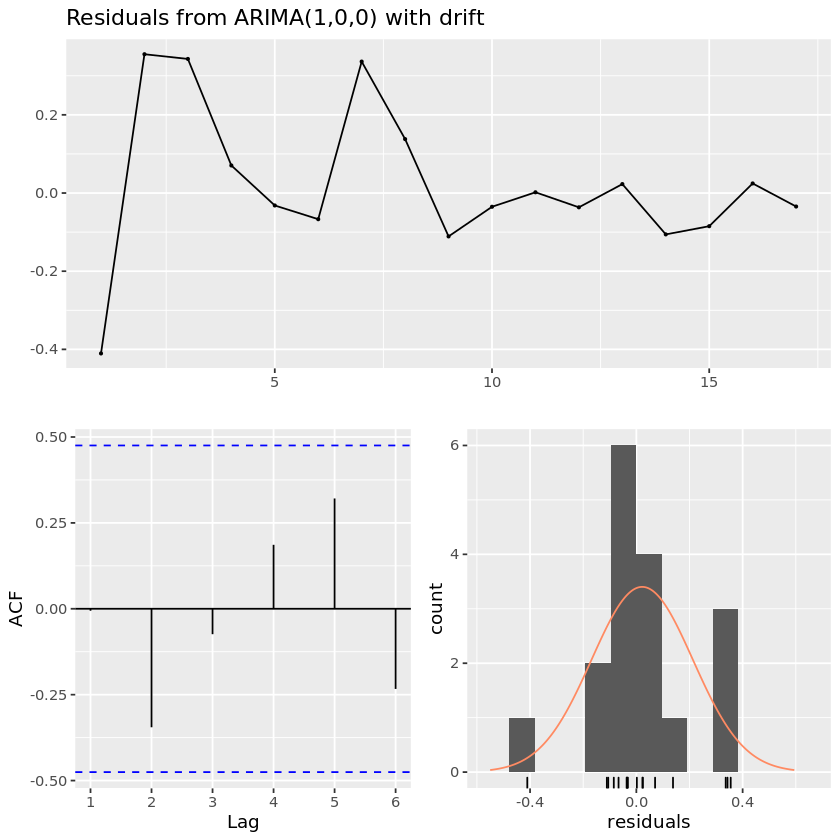

In [11]:
checkresiduals(mdl1)

In [12]:
# Compare to:
mdl1a<-Arima(master_gr$growth_croz,order=c(2,0,0),include.mean=F,include.drift=T)
summary(mdl1a)

Series: master_gr$growth_croz 
ARIMA(2,0,0) with drift 

Coefficients:
          ar1      ar2   drift
      -0.5079  -0.2469  0.0030
s.e.   0.2489   0.3604  0.0026

sigma^2 estimated as 0.04097:  log likelihood=4.53
AIC=-1.06   AICc=2.27   BIC=2.27

Training set error measures:
                     ME      RMSE       MAE  MPE MAPE      MASE        ACF1
Training set 0.02739753 0.1836951 0.1272164 -Inf  Inf 0.6380823 -0.02928708



	Ljung-Box test

data:  Residuals from ARIMA(2,0,0) with drift
Q* = 4.6634, df = 3, p-value = 0.1982

Model df: 3.   Total lags used: 6



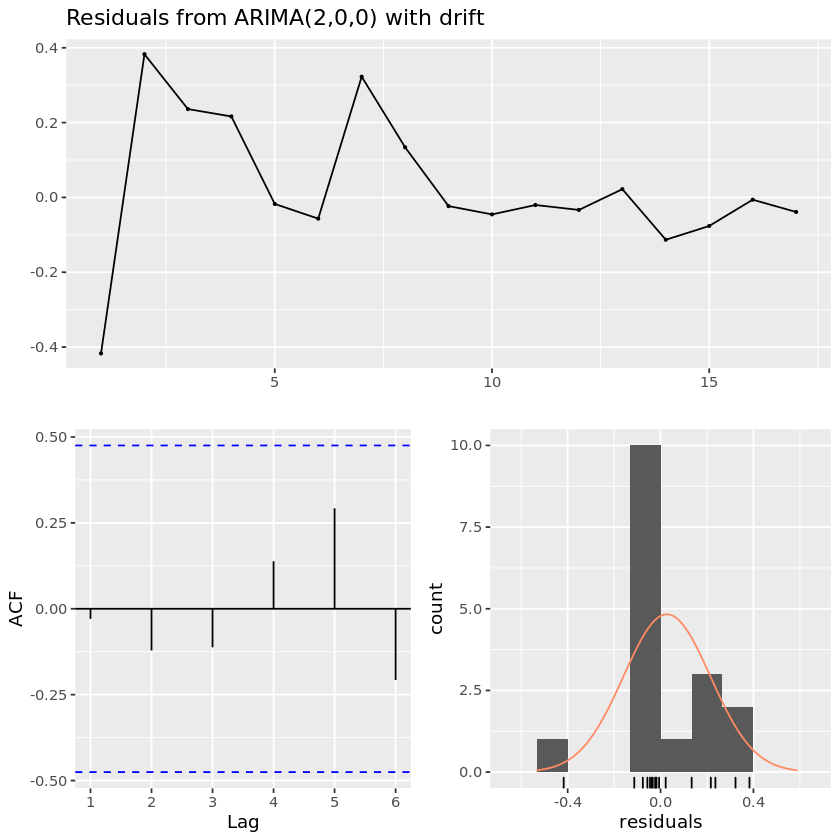

In [13]:
checkresiduals(mdl1a)

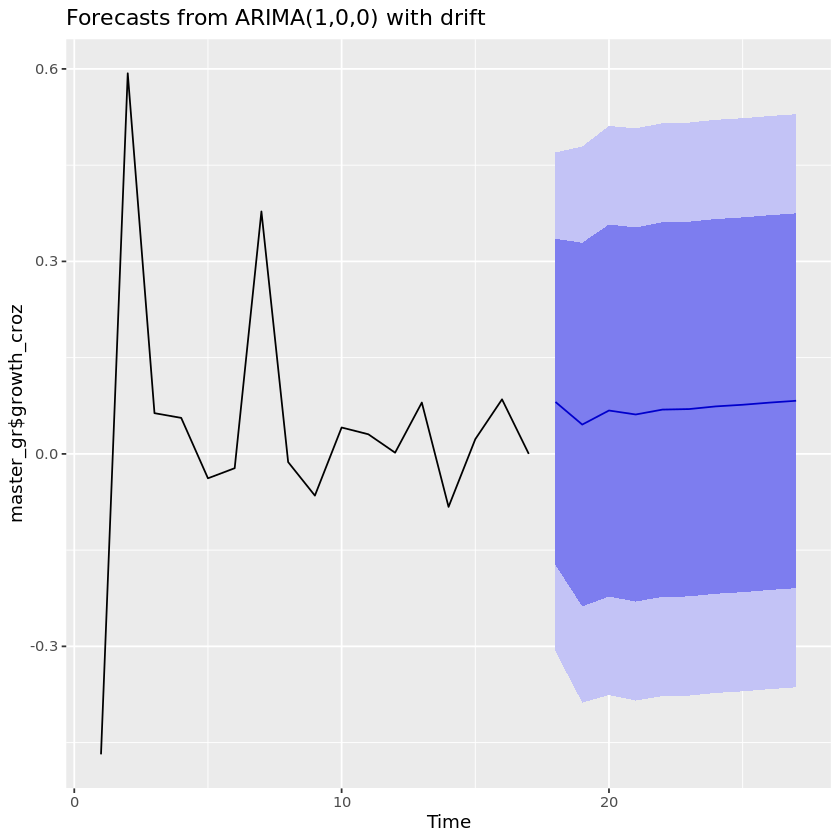

In [14]:
autoplot(forecast(mdl1))


# Plotting the correct trend

In [15]:
adcroz<-master_gr$growth_croz
names(adcroz)<-master_gr$year

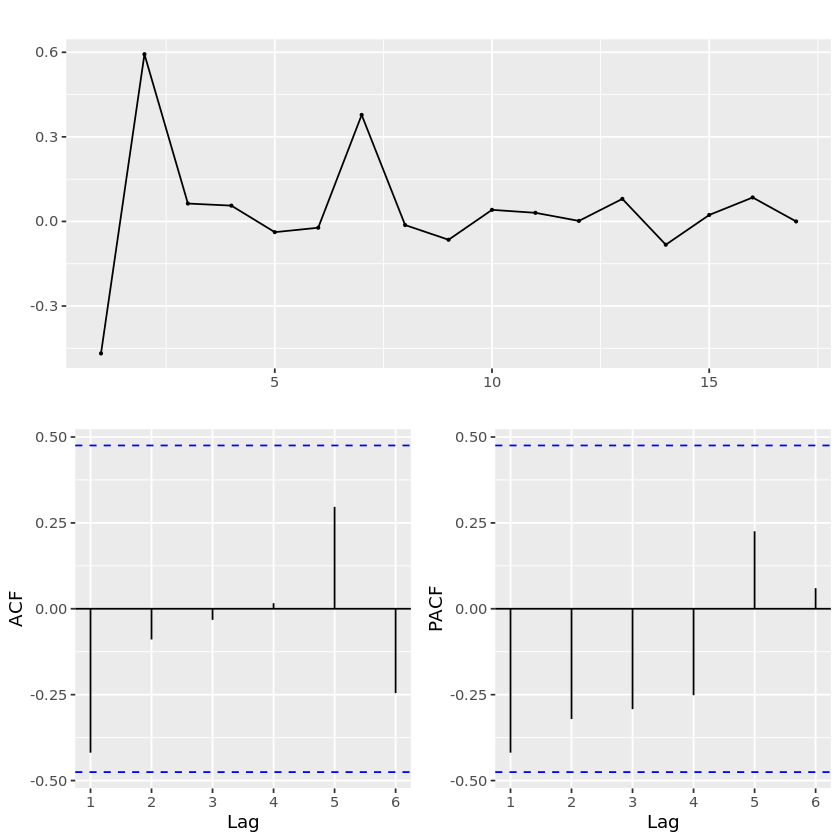

In [16]:
# Uncorrected trend
ggtsdisplay(adcroz)

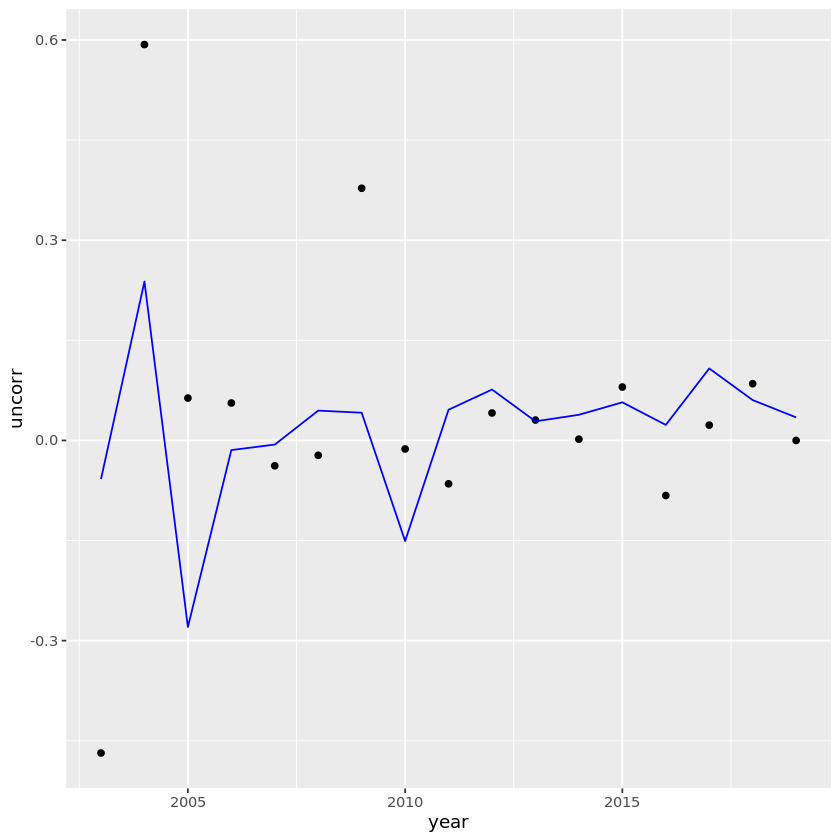

In [17]:
pdf<-data.frame(year=master_gr$year,uncorr=mdl1$x,corr=fitted(mdl1))
ggplot(pdf,aes(x=year,y=uncorr)) + geom_point() + geom_line(aes(y=corr),color="blue")

In [18]:
save(adcroz,pdf,file="/home/ubuntu/Workspace/Anthropocene/data/bestModeldata.RData")

## Removing drift term and including (1,0,0) structure

## 1st: VIF to select the environmental variables to include in the saturated model

In [19]:
#threshold at 10 (it’s equivalent to explaining 99% of the information in a variable by the set of the other covariates).

#select covariates based on variance inflation

vif_func<-function(in_frame,thresh=10,trace=T,...){
  
  
  
  if(class(in_frame) != 'data.frame') in_frame<-data.frame(in_frame)
  
  
  
  #get initial vif value for all comparisons of variables
  
  vif_init<-NULL
  
  var_names <- names(in_frame)
  
  for(val in var_names){
    
    regressors <- var_names[-which(var_names == val)]
    
    form <- paste(regressors, collapse = '+')
    
    form_in <- formula(paste(val, '~', form))
    
    vif_init<-rbind(vif_init, c(val, VIF(lm(form_in, data = in_frame, ...))))
    
  }
  
  vif_max<-max(as.numeric(vif_init[,2]), na.rm = TRUE)
  
  
  
  if(vif_max < thresh){
    
    if(trace==T){ #print output of each iteration
      
      prmatrix(vif_init,collab=c('var','vif'),rowlab=rep('',nrow(vif_init)),quote=F)
      
      cat('\n')
      
      cat(paste('All variables have VIF < ', thresh,', max VIF ',round(vif_max,2), sep=''),'\n\n')
      
    }
    
    return(var_names)
    
  }
  
  else{
    
    
    
    in_dat<-in_frame
    
    
    
    #backwards selection of explanatory variables, stops when all VIF values are below 'thresh'
    
    while(vif_max >= thresh){
      
      
      
      vif_vals<-NULL
      
      var_names <- names(in_dat)
      
      
      
      for(val in var_names){
        
        regressors <- var_names[-which(var_names == val)]
        
        form <- paste(regressors, collapse = '+')
        
        form_in <- formula(paste(val, '~', form))
        
        vif_add<-VIF(lm(form_in, data = in_dat, ...))
        
        vif_vals<-rbind(vif_vals,c(val,vif_add))
        
      }
      
      max_row<-which(vif_vals[,2] == max(as.numeric(vif_vals[,2]), na.rm = TRUE))[1]
      
      
      
      vif_max<-as.numeric(vif_vals[max_row,2])
      
      
      
      if(vif_max<thresh) break
      
      
      
      if(trace==T){ #print output of each iteration
        
        prmatrix(vif_vals,collab=c('var','vif'),rowlab=rep('',nrow(vif_vals)),quote=F)
        
        cat('\n')
        
        cat('removed: ',vif_vals[max_row,1],vif_max,'\n\n')
        
        flush.console()
        
      }
      
      
      
      in_dat<-in_dat[,!names(in_dat) %in% vif_vals[max_row,1]]
      
      
      
    }
    
    
    
    return(names(in_dat))
    
    
    
  }
  
  
  
}
  
vif_func(in_frame,thresh=10,trace=T)

 var           vif
 intP_RSP      Inf
 mnChl_aw_RSP  Inf
 nmSST_aw_RSP  Inf
 intP_MCM      Inf
 mnChl_aw_MCM  Inf
 mnOW_MCM      Inf
 nmSST_aw_MCM  Inf
 mnAirTemp     Inf
 mnWind        Inf
 mnSIE         Inf
 OW_day_RSP    Inf
 logOW_day_MCM Inf
 GyreSPD       Inf
 Salinity      Inf
 mnOW_RSP6     Inf
 SIE_lag5      Inf

removed:  intP_RSP Inf 

 var           vif
 mnChl_aw_RSP  Inf
 nmSST_aw_RSP  Inf
 intP_MCM      Inf
 mnChl_aw_MCM  Inf
 mnOW_MCM      Inf
 nmSST_aw_MCM  Inf
 mnAirTemp     Inf
 mnWind        Inf
 mnSIE         Inf
 OW_day_RSP    Inf
 logOW_day_MCM Inf
 GyreSPD       Inf
 Salinity      Inf
 mnOW_RSP6     Inf
 SIE_lag5      Inf

removed:  mnChl_aw_RSP Inf 

 var           vif
 nmSST_aw_RSP  Inf
 intP_MCM      Inf
 mnChl_aw_MCM  Inf
 mnOW_MCM      Inf
 nmSST_aw_MCM  Inf
 mnAirTemp     Inf
 mnWind        Inf
 mnSIE         Inf
 OW_day_RSP    Inf
 logOW_day_MCM Inf
 GyreSPD       Inf
 Salinity      Inf
 mnOW_RSP6     Inf
 SIE_lag5      Inf

removed:  nmSST_aw_RSP Inf 

 v

[1] "nmSST_aw_MCM"  "mnAirTemp"     "mnWind"        "mnSIE"        
[5] "OW_day_RSP"    "logOW_day_MCM" "GyreSPD"       "Salinity"     
[9] "mnOW_RSP6"

# Chl, and Productivity showed up as redundant variables, so I don't include them in the saturated model, specially because how difficult is to give a rationale to link productivity with anything at the Ross Sea
 

In [20]:
#correlation test
test <- cor.test(master_gr$nmSST_aw_RSP, master_gr$mnOW_RSP6, method= "spearman")
test

test <- cor.test(master_gr$SIE_lag4, master_gr$mnOW_RSP6_lag4, method= "spearman")
test



	Spearman's rank correlation rho

data:  master_gr$nmSST_aw_RSP and master_gr$mnOW_RSP6
S = 240, p-value = 0.008217
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6470588 



	Spearman's rank correlation rho

data:  master_gr$SIE_lag4 and master_gr$mnOW_RSP6_lag4
S = 580, p-value = 0.2593
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.2892157 


In [21]:
#correlation test
test <- cor.test(master_gr$nmSST_aw_RSP, master_gr$OW_day_RSP, method= "spearman")
test

Warning message in cor.test.default(master_gr$nmSST_aw_RSP, master_gr$OW_day_RSP, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  master_gr$nmSST_aw_RSP and master_gr$OW_day_RSP
S = 962.5, p-value = 0.1095
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.4154467 


In [22]:
#test alternative models wisthout SST, 
#"nmSST_aw_RSP", "SIE_lag4", "GyreSPD", "GyreSPD_2", "Fish_cum3", "mnAirTemp_lag5"
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD", "GyreSPD_2", "Fish_cum3", "mnAirTemp_lag5", "OW_day_RSPlag4")])
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD  GyreSPD_2  Fish_cum3  mnAirTemp_lag5
      -0.8645   -0.1942  -0.0480     0.0072      0.007         -0.1130
s.e.   0.1309    0.1249   0.1182     0.0108      0.002          0.0251
      OW_day_RSPlag4
             -0.0268
s.e.          0.0053

sigma^2 estimated as 0.01325:  log likelihood=15.17
AIC=-14.34   AICc=9.66   BIC=-8.67

Training set error measures:
                       ME       RMSE        MAE     MPE     MAPE      MASE
Training set -0.006850524 0.08407141 0.06297958 -41.321 252.6145 0.3158881
                   ACF1
Training set -0.2969202


# Saturated model

In [23]:
#MODEL 1
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE", "GyreSPD", 
                              "mnWind",   "Fish_cum3",
                                       "mnAirTemp",  "OW_day_RSP")]) #, "mnOW_RSP6"
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  GyreSPD   mnWind  Fish_cum3  mnAirTemp  OW_day_RSP
      -0.7555  0.1122   0.0470  -0.0812    -0.0012    -0.0483     -0.0115
s.e.   0.2282  0.1937   0.0569   0.0836     0.0055     0.0613      0.0101

sigma^2 estimated as 0.04444:  log likelihood=6.36
AIC=3.28   AICc=27.28   BIC=8.94

Training set error measures:
                      ME      RMSE       MAE      MPE    MAPE      MASE
Training set -0.01604534 0.1539457 0.1355301 298.2586 579.274 0.6797811
                    ACF1
Training set -0.04463834


In [24]:
coeftest(mdlsat)


z test of coefficients:

             Estimate Std. Error z value  Pr(>|z|)    
ar1        -0.7555258  0.2281568 -3.3114 0.0009282 ***
av_SIE      0.1122351  0.1936919  0.5795 0.5622845    
GyreSPD     0.0469895  0.0569229  0.8255 0.4090915    
mnWind     -0.0812132  0.0835553 -0.9720 0.3310661    
Fish_cum3  -0.0011656  0.0055284 -0.2108 0.8330136    
mnAirTemp  -0.0482541  0.0613013 -0.7872 0.4311870    
OW_day_RSP -0.0114577  0.0101470 -1.1292 0.2588233    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [25]:
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE", "GyreSPD", 
                              "mnWind",   "Fish_cum3",
                                       "mnAirTemp", "OW_day_RSP")]) #, "mnOW_RSP6", "OW_day_RSP" 
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  GyreSPD   mnWind  Fish_cum3  mnAirTemp  OW_day_RSP
      -0.7555  0.1122   0.0470  -0.0812    -0.0012    -0.0483     -0.0115
s.e.   0.2282  0.1937   0.0569   0.0836     0.0055     0.0613      0.0101

sigma^2 estimated as 0.04444:  log likelihood=6.36
AIC=3.28   AICc=27.28   BIC=8.94

Training set error measures:
                      ME      RMSE       MAE      MPE    MAPE      MASE
Training set -0.01604534 0.1539457 0.1355301 298.2586 579.274 0.6797811
                    ACF1
Training set -0.04463834


In [26]:
coeftest(mdlsat)


z test of coefficients:

             Estimate Std. Error z value  Pr(>|z|)    
ar1        -0.7555258  0.2281568 -3.3114 0.0009282 ***
av_SIE      0.1122351  0.1936919  0.5795 0.5622845    
GyreSPD     0.0469895  0.0569229  0.8255 0.4090915    
mnWind     -0.0812132  0.0835553 -0.9720 0.3310661    
Fish_cum3  -0.0011656  0.0055284 -0.2108 0.8330136    
mnAirTemp  -0.0482541  0.0613013 -0.7872 0.4311870    
OW_day_RSP -0.0114577  0.0101470 -1.1292 0.2588233    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


# Including lags

In [27]:
#"SIE_lag5"
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE","SIE_lag5", "GyreSPD", 
                              "mnWind",  "OW_day_RSP",  "Fish_cum3",
                                       "mnAirTemp")]) # "mnOW_RSP6"
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  SIE_lag5  GyreSPD   mnWind  OW_day_RSP  Fish_cum3
      -0.8048  0.2230   -0.2052   0.0095  -0.0060     -0.0169    -0.0036
s.e.   0.2040  0.2082    0.1900   0.0638   0.1051      0.0107     0.0058
      mnAirTemp
        -0.0395
s.e.     0.0580

sigma^2 estimated as 0.04656:  log likelihood=6.91
AIC=4.18   AICc=40.18   BIC=10.55

Training set error measures:
                      ME      RMSE       MAE      MPE    MAPE      MASE
Training set -0.01578419 0.1474115 0.1153096 508.9381 651.149 0.5783607
                    ACF1
Training set -0.01588263


In [28]:
coeftest(mdlsat)


z test of coefficients:

             Estimate Std. Error z value  Pr(>|z|)    
ar1        -0.8048090  0.2040013 -3.9451 7.976e-05 ***
av_SIE      0.2230055  0.2081626  1.0713    0.2840    
SIE_lag5   -0.2051826  0.1899598 -1.0801    0.2801    
GyreSPD     0.0094861  0.0637832  0.1487    0.8818    
mnWind     -0.0060279  0.1050528 -0.0574    0.9542    
OW_day_RSP -0.0169333  0.0107119 -1.5808    0.1139    
Fish_cum3  -0.0035641  0.0057523 -0.6196    0.5355    
mnAirTemp  -0.0394754  0.0579921 -0.6807    0.4961    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [29]:
#6
#SIE_lag4",
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE", "SIE_lag4", "GyreSPD", 
                              "mnWind",  "OW_day_RSP",  "Fish_cum3",
                                       "mnAirTemp")]) #, "mnOW_RSP6"
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  SIE_lag4  GyreSPD   mnWind  OW_day_RSP  Fish_cum3
      -0.8130  0.2071   -0.2070   0.0357  -0.0200     -0.0173    -0.0021
s.e.   0.1932  0.1792    0.1184   0.0500   0.0822      0.0095     0.0050
      mnAirTemp
        -0.0342
s.e.     0.0546

sigma^2 estimated as 0.04172:  log likelihood=7.72
AIC=2.57   AICc=38.57   BIC=8.94

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.01400865 0.1395356 0.1056001 581.2375 646.2865 0.5296609
                   ACF1
Training set -0.1099015


In [30]:
coeftest(mdlsat)


z test of coefficients:

             Estimate Std. Error z value  Pr(>|z|)    
ar1        -0.8129578  0.1931820 -4.2082 2.574e-05 ***
av_SIE      0.2070959  0.1791995  1.1557   0.24782    
SIE_lag4   -0.2069905  0.1183689 -1.7487   0.08034 .  
GyreSPD     0.0356896  0.0499823  0.7140   0.47520    
mnWind     -0.0199909  0.0822065 -0.2432   0.80787    
OW_day_RSP -0.0172502  0.0095047 -1.8149   0.06954 .  
Fish_cum3  -0.0020971  0.0049945 -0.4199   0.67457    
mnAirTemp  -0.0342036  0.0546043 -0.6264   0.53106    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [31]:
#SIE_lag4", "nmSST_aw_RSP_lag5" and "nmSST_aw_RSP_lag4",,
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE", "SIE_lag4", "GyreSPD", 
                              "mnWind",  "OW_day_RSP", "OW_day_RSPlag4", "Fish_cum3",
                                       "mnAirTemp")]) #, "mnOW_RSP6"
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  SIE_lag4  GyreSPD  mnWind  OW_day_RSP  OW_day_RSPlag4
      -0.8282  0.0249   -0.0982   0.0154  0.0390     -0.0145         -0.0201
s.e.   0.1588  0.1622    0.1065   0.0425  0.0715      0.0079          0.0079
      Fish_cum3  mnAirTemp
         0.0041     0.0099
s.e.     0.0048     0.0481

sigma^2 estimated as 0.03356:  log likelihood=10.47
AIC=-0.94   AICc=54.06   BIC=6.15

Training set error measures:
                       ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.009757028 0.1158603 0.1001847 274.3638 439.0831 0.5024984
                   ACF1
Training set -0.2571026


In [32]:
coeftest(mdlsat)


z test of coefficients:

                 Estimate Std. Error z value  Pr(>|z|)    
ar1            -0.8281531  0.1588185 -5.2145 1.844e-07 ***
av_SIE          0.0248650  0.1622022  0.1533   0.87816    
SIE_lag4       -0.0981852  0.1064520 -0.9223   0.35635    
GyreSPD         0.0154260  0.0425219  0.3628   0.71677    
mnWind          0.0390251  0.0715100  0.5457   0.58525    
OW_day_RSP     -0.0145397  0.0079373 -1.8318   0.06698 .  
OW_day_RSPlag4 -0.0201297  0.0078902 -2.5512   0.01073 *  
Fish_cum3       0.0041302  0.0047850  0.8631   0.38806    
mnAirTemp       0.0098830  0.0481103  0.2054   0.83724    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [33]:
#5
#"mnOW_RSP6_lag5" and "mnOW_RSP6_lag4" 
cov_sat_growth<-as.matrix(master_gr[,c("av_SIE", "SIE_lag4", "GyreSPD", 
                              "mnWind",  "OW_day_RSP", "Fish_cum3", "mnAirTemp",
                                       "mnAirTemp_lag5")]) #, "mnOW_RSP6_lag5", , "mnOW_RSP6"
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  av_SIE  SIE_lag4  GyreSPD   mnWind  OW_day_RSP  Fish_cum3
      -0.7086  0.0944   -0.3270   0.0343  -0.0085     -0.0148    -0.0011
s.e.   0.3496  0.2197    0.1409   0.0480   0.0855      0.0091     0.0050
      mnAirTemp  mnAirTemp_lag5
        -0.0630         -0.0722
s.e.     0.0567          0.0509

sigma^2 estimated as 0.04244:  log likelihood=8.94
AIC=2.13   AICc=57.13   BIC=9.21

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE     MASE
Training set -0.01234267 0.1302925 0.1041794 717.7501 748.3674 0.522535
                   ACF1
Training set -0.0324882


In [34]:
coeftest(mdlsat)
                    


z test of coefficients:

                 Estimate Std. Error z value Pr(>|z|)  
ar1            -0.7086324  0.3495778 -2.0271  0.04265 *
av_SIE          0.0944405  0.2196508  0.4300  0.66723  
SIE_lag4       -0.3269633  0.1408895 -2.3207  0.02030 *
GyreSPD         0.0343346  0.0479993  0.7153  0.47441  
mnWind         -0.0085206  0.0855387 -0.0996  0.92065  
OW_day_RSP     -0.0148456  0.0090759 -1.6357  0.10190  
Fish_cum3      -0.0010501  0.0050001 -0.2100  0.83366  
mnAirTemp      -0.0629656  0.0567393 -1.1097  0.26711  
mnAirTemp_lag5 -0.0721574  0.0509310 -1.4168  0.15655  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [35]:
#4
#INCLUDING GYRE LAG
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD_lag4",
                                "OW_day_RSP", "Fish_cum3",
                                       "mnAirTemp_lag5")]) 
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD_lag4  OW_day_RSP  Fish_cum3  mnAirTemp_lag5
      -0.8014   -0.2606        0.1161     -0.0182    -0.0051         -0.0634
s.e.   0.2072    0.0812        0.0326      0.0051     0.0028          0.0316

sigma^2 estimated as 0.02164:  log likelihood=11.21
AIC=-8.42   AICc=5.58   BIC=-3.01

Training set error measures:
                       ME      RMSE        MAE      MPE     MAPE      MASE
Training set -0.009728294 0.1162853 0.09111146 115.6736 320.5436 0.4569898
                   ACF1
Training set 0.07277124


In [36]:
coeftest(mdlsat)


z test of coefficients:

                 Estimate Std. Error z value  Pr(>|z|)    
ar1            -0.8013850  0.2072241 -3.8672 0.0001101 ***
SIE_lag4       -0.2606381  0.0811846 -3.2104 0.0013253 ** 
GyreSPD_lag4    0.1161489  0.0326086  3.5619 0.0003682 ***
OW_day_RSP     -0.0181942  0.0051090 -3.5612 0.0003692 ***
Fish_cum3      -0.0051124  0.0027761 -1.8416 0.0655351 .  
mnAirTemp_lag5 -0.0634062  0.0315973 -2.0067 0.0447821 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [37]:
#4
#INCLUDING OW LAG
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD_lag4",
                                "OW_day_RSPlag4", 
                                       "mnAirTemp_lag5")]) 
mdlsat<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdlsat)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD_lag4  OW_day_RSPlag4  mnAirTemp_lag5
      -0.5733   -0.1843        0.0220         -0.0101         -0.0977
s.e.   0.2984    0.1116        0.0317          0.0058          0.0451

sigma^2 estimated as 0.02759:  log likelihood=9.16
AIC=-6.31   AICc=2.09   BIC=-1.32

Training set error measures:
                       ME     RMSE       MAE MPE MAPE      MASE      ACF1
Training set -0.009903815 0.139552 0.1101155 Inf  Inf 0.5523085 0.1033146


### Explored different percentages weights for cum_fish
Fish= Total Tonnes * Perc.134/100  
Fish_cum3; 3 years cumulative, no weights  
Fish_cum_8_9_1; 3 years cumulative, weights: 80%, 90% ,100%  
Fish_cum_6_8_1; 3 years cumulative, weights: 60%, 80% ,100%  
Fish_cum_75_1; 2 years cumulative, weights: 75%, 100%  
Fish_cum; 2 years cumulative, no weights  
Fish_cum_5_1; 2 years cumulative, weights: 50%, 100%  
Fish_cum_4_1; 2 years cumulative, weights: 40%, 100%  
Fish_cum_2_1; 2 years cumulative, weights: 20%, 100%  

## TOP MODEL
After exploring numerous options of variables and lags, the below is the top model. Note that removing air temperature effects increases the AIC score to -6.65, which is not two units less than the top model and arguably implies that including the air temprature effects is not warranted for parsimony reasons. However, the covariance of the air temperature effects with the fish effects makes fish effects become significant (or nearly so), thus we keep it. Similarly, removing the fish effects reduces the top model to a very competitive AIC of -7.81, or only 0.61 AIC units above the top model. Yet, the reduced model without fish effects makes the inclusion of air temperature effects unjustifiable. Removing both effects makes for a much less competitie model. Below it, we fit reduced versions to assess component contributions.

In [38]:
cov_sat_growth_top<-as.matrix(master_gr[,c("GyreSPD_lag4", "SIE_lag4", "OW_day_RSP", "Fish_cum3","mnAirTemp_lag5")]) 
#"GyreSPD", "SIE_lag4", "OW_day_RSPlag4", "Fish_cum3","mnAirTemp_lag5"
topModel<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth_top)
summary(topModel)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  GyreSPD_lag4  SIE_lag4  OW_day_RSP  Fish_cum3  mnAirTemp_lag5
      -0.8014        0.1161   -0.2606     -0.0182    -0.0051         -0.0634
s.e.   0.2072        0.0326    0.0812      0.0051     0.0028          0.0316

sigma^2 estimated as 0.02164:  log likelihood=11.21
AIC=-8.42   AICc=5.58   BIC=-3.01

Training set error measures:
                       ME      RMSE        MAE      MPE     MAPE      MASE
Training set -0.009728294 0.1162853 0.09111146 115.6736 320.5436 0.4569898
                   ACF1
Training set 0.07277124


In [39]:
coeftest(topModel)


z test of coefficients:

                 Estimate Std. Error z value  Pr(>|z|)    
ar1            -0.8013850  0.2072241 -3.8672 0.0001101 ***
GyreSPD_lag4    0.1161489  0.0326086  3.5619 0.0003682 ***
SIE_lag4       -0.2606381  0.0811846 -3.2104 0.0013253 ** 
OW_day_RSP     -0.0181942  0.0051090 -3.5612 0.0003692 ***
Fish_cum3      -0.0051124  0.0027761 -1.8416 0.0655351 .  
mnAirTemp_lag5 -0.0634062  0.0315973 -2.0067 0.0447821 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [40]:
## Let's create the calc_R2 function
## We will define it as the usual OLS, even though it includes the ARIMA component, which is technically not a covariate
calc_R2<-function(mdl){
    tdf<-data.frame(y=mdl$x, resid=mdl$residuals)
    tdf<-na.omit(tdf)
    ymean<-mean(tdf$y)
    tdf$sseY<-(tdf$y-ymean)^2
    ssT<-sum(tdf$sseY)
    ssE<-sum(tdf$resid^2)
    n<-nrow(tdf)
    p<-length(mdl$coef)
    rSq<-1-(ssE/ssT)
    adrSq<-1 - ((ssE/(n-p))/(ssT/(n-1)))
    print(paste("R-squared:",round(rSq,3),"   Adjusted R-squared:",round(adrSq,3)))
}


In [41]:
calc_R2(topModel)

[1] "R-squared: 0.701    Adjusted R-squared: 0.551"


In [42]:
#reducing one variable at the time: no Gyre
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "OW_day_RSP", "Fish_cum3", "mnAirTemp_lag5")]) 
mdl_noGyre<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdl_noGyre)
calc_R2(mdl_noGyre)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  OW_day_RSP  Fish_cum3  mnAirTemp_lag5
      -0.0642   -0.2066     -0.0110     0.0014         -0.1301
s.e.   0.6288    0.1571      0.0079     0.0048          0.0829

sigma^2 estimated as 0.03298:  log likelihood=7.59
AIC=-3.18   AICc=6.16   BIC=1.46

Training set error measures:
                        ME      RMSE       MAE      MPE    MAPE      MASE
Training set -8.548835e-05 0.1505739 0.1132767 557.6419 620.754 0.5681643
                    ACF1
Training set 0.002861032
[1] "R-squared: 0.499    Adjusted R-squared: 0.316"


In [43]:
#reducing one variable at the time: no SIE_lag4
cov_sat_growth<-as.matrix(master_gr[,c("GyreSPD_lag4", "OW_day_RSP", "Fish_cum3", "mnAirTemp_lag5")]) 
mdl_noSIE<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdl_noSIE)
calc_R2(mdl_noSIE)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  GyreSPD_lag4  OW_day_RSP  Fish_cum3  mnAirTemp_lag5
      -0.7052        0.0443     -0.0165    -0.0030          0.0058
s.e.   0.2360        0.0345      0.0068     0.0037          0.0298

sigma^2 estimated as 0.03291:  log likelihood=7.26
AIC=-2.52   AICc=6.81   BIC=2.11

Training set error measures:
                      ME      RMSE       MAE      MPE     MAPE      MASE
Training set -0.01662551 0.1504202 0.1297336 148.4338 448.4936 0.6507079
                   ACF1
Training set 0.07489609
[1] "R-squared: 0.5    Adjusted R-squared: 0.318"


In [44]:
#reducing one variable at the time: no OW_day_RSP
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD_lag4", "Fish_cum3", "mnAirTemp_lag5")]) 
mdl_noSST<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdl_noSST)
calc_R2(mdl_noSST)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD_lag4  Fish_cum3  mnAirTemp_lag5
      -0.5036   -0.2580        0.0459    -0.0011          -0.102
s.e.   0.3303    0.1205        0.0410     0.0041           0.050

sigma^2 estimated as 0.03465:  log likelihood=7.05
AIC=-2.1   AICc=7.24   BIC=2.54

Training set error measures:
                      ME      RMSE       MAE       MPE     MAPE      MASE
Training set -0.01017178 0.1543352 0.1250862 -221.5304 541.3537 0.6273975
                   ACF1
Training set 0.05340967
[1] "R-squared: 0.473    Adjusted R-squared: 0.282"


In [45]:
#reducing one variable at the time: no Fish_cum3
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD_lag4", "OW_day_RSP", "mnAirTemp_lag5")]) 
#"GyreSPD_lag4", "SIE_lag4", "OW_day_RSP", "Fish_cum3","mnAirTemp_lag5"
mdl_noFish<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdl_noFish)
calc_R2(mdl_noFish)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD_lag4  OW_day_RSP  mnAirTemp_lag5
      -0.5984   -0.2498        0.0838     -0.0154         -0.0677
s.e.   0.2868    0.0996        0.0329      0.0058          0.0413

sigma^2 estimated as 0.02402:  log likelihood=9.9
AIC=-7.81   AICc=1.52   BIC=-3.17

Training set error measures:
                       ME      RMSE      MAE      MPE     MAPE      MASE
Training set -0.008377604 0.1285031 0.102767 312.0059 442.0791 0.5154509
                  ACF1
Training set 0.1052669
[1] "R-squared: 0.635    Adjusted R-squared: 0.502"


In [46]:
#reducing one variable at the time: no mnAirTemp_lag5
cov_sat_growth<-as.matrix(master_gr[,c("SIE_lag4", "GyreSPD_lag4", "OW_day_RSP", "Fish_cum3")]) 
mdl_noAirT<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F,xreg= cov_sat_growth)
summary(mdl_noAirT)
calc_R2(mdl_noAirT)

Series: master_gr$growth_croz 
Regression with ARIMA(1,0,0) errors 

Coefficients:
          ar1  SIE_lag4  GyreSPD_lag4  OW_day_RSP  Fish_cum3
      -0.8006   -0.1413        0.1144     -0.0203    -0.0045
s.e.   0.1905    0.0628        0.0366      0.0056     0.0031

sigma^2 estimated as 0.0249:  log likelihood=9.32
AIC=-6.65   AICc=2.68   BIC=-2.01

Training set error measures:
                      ME      RMSE        MAE      MPE     MAPE      MASE
Training set -0.01029302 0.1308432 0.09971205 114.5294 323.8099 0.5001279
                   ACF1
Training set -0.0286001
[1] "R-squared: 0.621    Adjusted R-squared: 0.484"


In [47]:
#Intercept_only model
mdl_Intonly<-Arima(master_gr$growth_croz,order=c(1,0,0),include.mean=F,include.drift=F)
summary(mdl_Intonly)
calc_R2(mdl_Intonly)

Series: master_gr$growth_croz 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.4466
s.e.   0.2481

sigma^2 estimated as 0.03916:  log likelihood=3.82
AIC=-3.65   AICc=-2.79   BIC=-1.98

Training set error measures:
                     ME      RMSE       MAE MPE MAPE      MASE       ACF1
Training set 0.05931076 0.1919774 0.1302301 Inf  Inf 0.6531978 -0.1072635
[1] "R-squared: 0.136    Adjusted R-squared: 0.136"


#### END OF MODEL SELECTIONS
******************************************************************************

# We explored all the cuadratics and none improved the best model

## Some additional checks


	Ljung-Box test

data:  Residuals from Regression with ARIMA(1,0,0) errors
Q* = 17.925, df = 9, p-value = 0.03605

Model df: 6.   Total lags used: 15



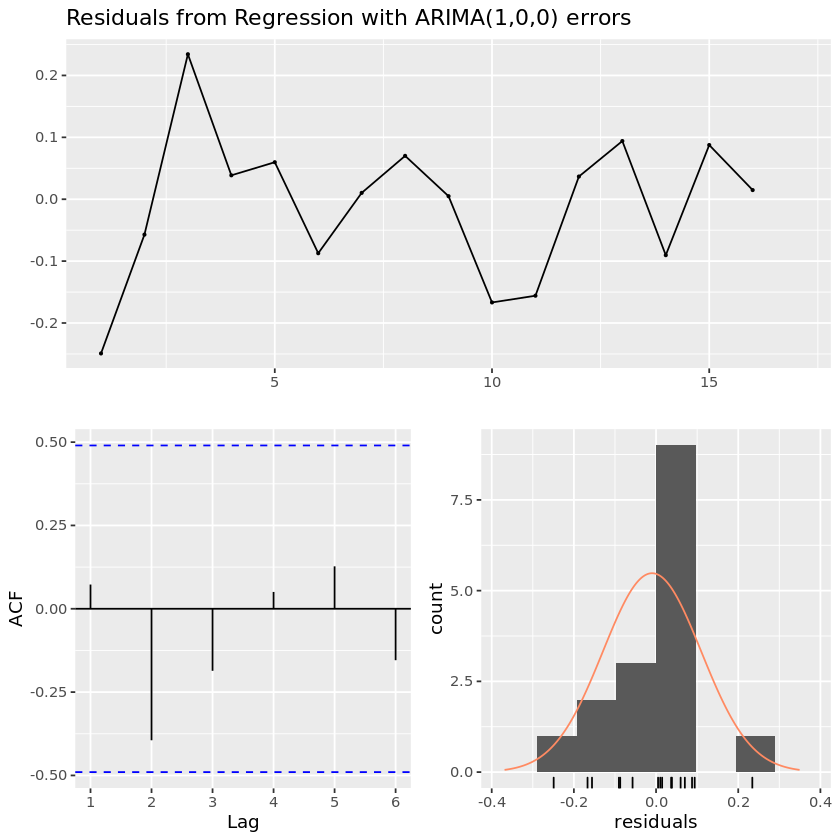

In [48]:
checkresiduals (topModel, lag=15)

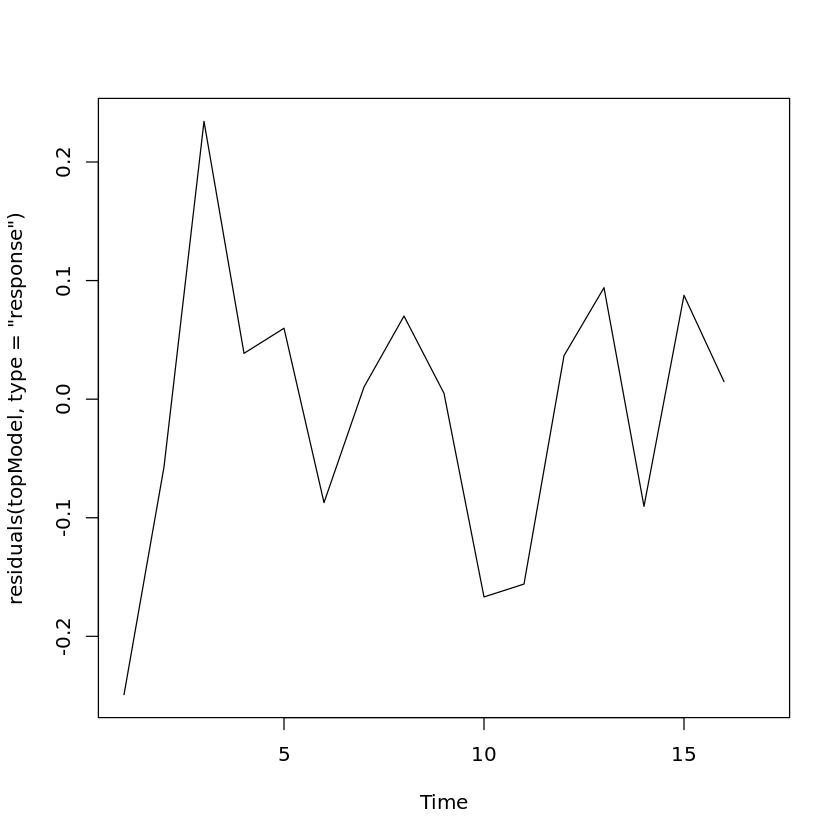

In [49]:
plot(residuals(topModel, type="response"))

In [50]:
save(master_gr,topModel,cov_sat_growth_top,file="/home/ubuntu/Workspace/Anthropocene/data/bestModelfit.RData")

# Checking for correlations

In [51]:
in_frame <- master_gr %>% select (av_SIE, GyreSPD, 
                              mnWind,   Fish_cum3,
                                       mnAirTemp, mnOW_RSP6)

In [52]:
vif_func(in_frame,thresh=10,trace=T)

 var       vif             
 av_SIE    1.50323447612792
 GyreSPD   1.60573710420611
 mnWind    1.20057577285539
 Fish_cum3 1.50452210191365
 mnAirTemp 1.58857314616331
 mnOW_RSP6 1.27190060662479

All variables have VIF < 10, max VIF 1.61 



[1] "av_SIE"    "GyreSPD"   "mnWind"    "Fish_cum3" "mnAirTemp" "mnOW_RSP6"

# Partial dependence plots

In [53]:
## function to generate the data
# df is the source data.frame (master_gr)
# varv is the variable for which to construct the partial dependence plot
# meanmed indicates if fixing other variables to their mean or median value
# mdl is the model in which to evaluate the partial dependence
# type indicates if evaluating the dependence on a sequence of the predictor values or their real values
getPDdata<-function(df,varv, meanmed="mean", mdl, type="seq"){
    #get fixed values of constant vars
    cvars<-names(coef(mdl)); cvars<-cvars[which(!cvars %in% c(varv,"ar1","ar2","ar3"))]
    pddc<-sapply(cvars,function(vv,df,meanmed){
        mvv<-ifelse(meanmed=="mean",mean(df[,vv],na.rm=T),median(df[,vv],na.rm=T))
    },df=df,meanmed=meanmed)
    
    #get varying values of partial dependence var
    if(type=="seq"){
        minprv<-min(df[,varv],na.rm=T); maxprv<-max(df[,varv],na.rm=T)
        prv<-seq(minprv,maxprv,length.out=nrow(df))
    }else{
        prv<-unique(df[,varv])
    }
    pddf<-data.frame(prv=prv);names(pddf)<-varv
    
    #combine into matrix
    for(ii in 1:NROW(pddc)){
        cvn<-pddc[ii]; cvnn<-cvars[ii]
        pddf<-cbind(pddf,cvnv=rep(cvn,nrow(pddf)))
        names(pddf)<-gsub("cvnv",cvnn,names(pddf))
    }
    #must re-order as in the original matrix used to train the model
    cvars<-names(coef(mdl)); cvars<-cvars[which(!cvars %in% c("ar1","ar2","ar3"))]
    pddf<-pddf[,cvars]
    pdmx<-as.matrix(pddf)
    
    preds<-forecast(mdl,xreg=pdmx,level=95)
    plotdata<-data.frame(varv=prv,meanv=as.numeric(preds$mean),
                         lcv=as.numeric(preds$lower),ucv=as.numeric(preds$upper))
    names(plotdata)<-gsub("varv",varv,names(plotdata))
    return(plotdata)
}



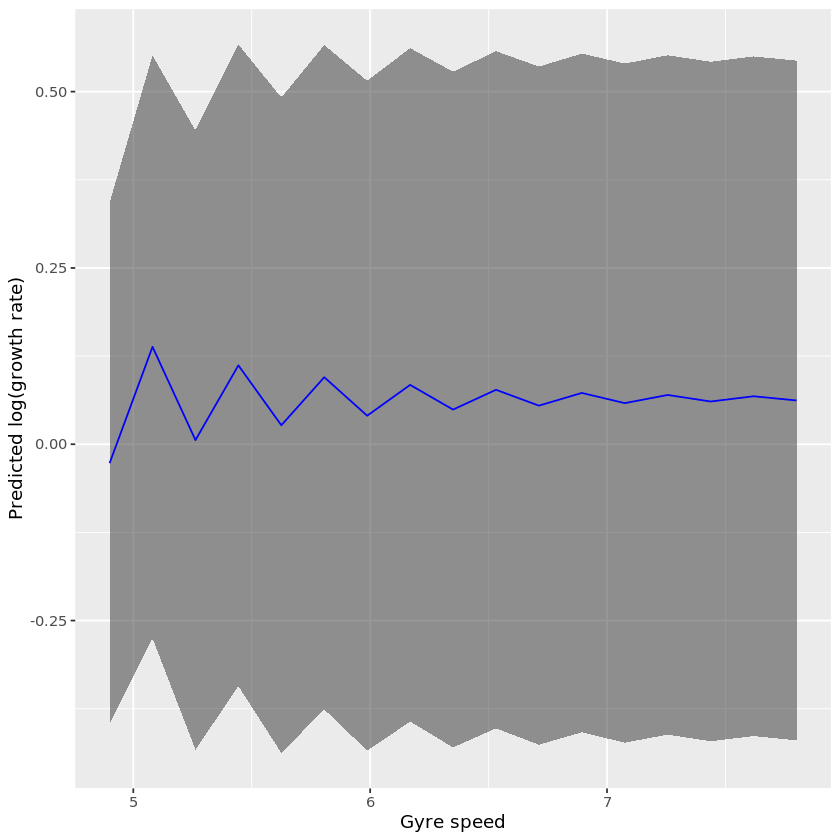

In [54]:
# "SIE_lag4", "GyreSPD", "nmSST_aw_RSP", "Fish_cum3", "mnAirTemp_lag5"
pdat<-getPDdata(df=master_gr,varv="GyreSPD",mdl=topModel)
ggplot(pdat,aes(x=GyreSPD,y=meanv)) + geom_ribbon(aes(ymin=lcv,ymax=ucv),alpha=0.5) + geom_line(color="blue") +
    labs(x="Gyre speed", y = "Predicted log(growth rate)")

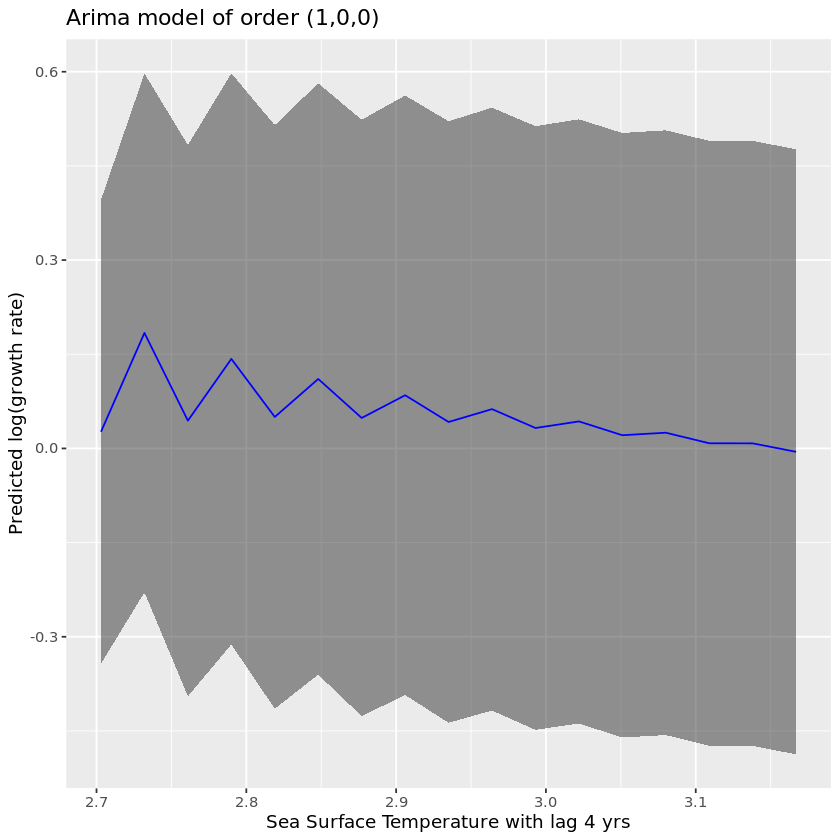

In [55]:
#nmSST_aw_RSP
pdat<-getPDdata(df=master_gr,varv="SIE_lag4",mdl=topModel)
ggplot(pdat,aes(x=SIE_lag4,y=meanv)) + geom_ribbon(aes(ymin=lcv,ymax=ucv),alpha=0.5) + geom_line(color="blue") +
    labs(x="Sea Surface Temperature with lag 4 yrs", y = "Predicted log(growth rate)", title="Arima model of order (1,0,0)")

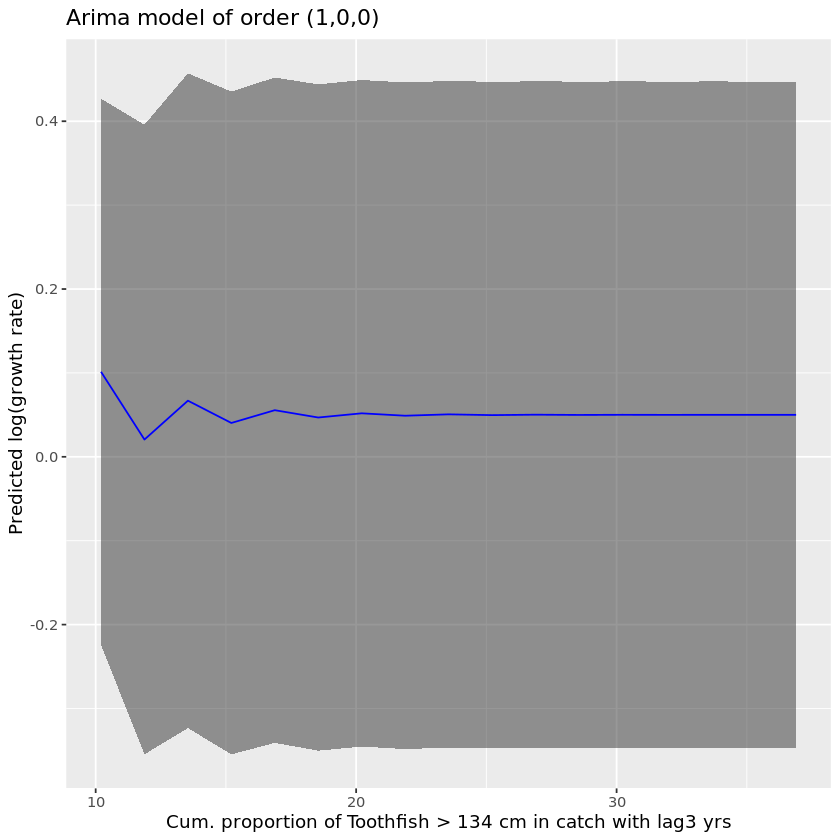

In [56]:
pdat<-getPDdata(df=master_gr,varv="Fish_cum3",mdl=mdlsat)
ggplot(pdat,aes(x=Fish_cum3,y=meanv)) + geom_ribbon(aes(ymin=lcv,ymax=ucv),alpha=0.5) + geom_line(color="blue") +
    labs(x="Cum. proportion of Toothfish > 134 cm in catch with lag3 yrs", y = "Predicted log(growth rate)", title="Arima model of order (1,0,0)")